In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
shapefile = os.path.join("..", "data", "boundaries", "uk_generalized_2015.shp")
print(shapefile)

..\data\boundaries\uk_generalized_2015.shp


In [3]:
map_df = gpd.read_file(shapefile)

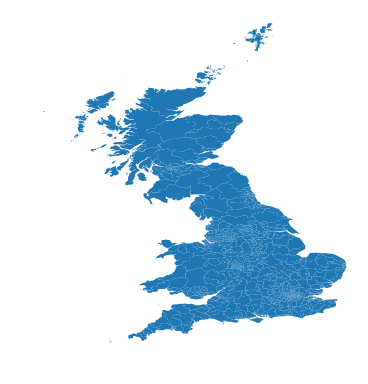

In [4]:
f, ax = plt.subplots(1, figsize=(6, 16))
ax = map_df.plot(ax=ax)
ax.set_axis_off()
plt.show()